<h1>TITANIC COMPETITION</h1>

This machine learning project was created for the Kaggle Titanic Dataset Competition. It uses linear regression and has so far been able to predict with 76.7% accuracy.

<h1>IMPORTS</h1>

In [536]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

dftr=pd.read_csv('datasets/train.csv')
dftr.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h1>DATA PREPROCESSING</h1>

In [537]:
dftr.drop(['Name','Ticket', "Cabin", "PassengerId"],axis=1,inplace=True)

In [538]:
nan_rows = dftr[dftr.isna().any(axis=1)]
dftr['Embarked'].fillna("Q", inplace=True)
dftr['Sex'] = dftr['Sex'].replace({'female': 0, 'male': 1})
# dftr['Embarked'] = dftr['Embarked'].replace({'S': 0, 'C': 1, "Q" : 2}).astype(int)

embarked_encoded_train = pd.get_dummies(dftr["Embarked"], prefix="Embarked")
dftr = pd.concat([dftr, embarked_encoded_train], axis=1)
dftr = dftr.drop("Embarked", axis=1)

dftr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


In [539]:
print(dftr.dtypes)

Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


In [540]:
print(dftr["Age"].median())
print(dftr["Age"].mean())
skewness = dftr["Age"].skew()
print("Skewness:", skewness)
# As skewness is 0.38, it is slightly skewed to the right. So the mean is greater than the median. So I will use the mean of mean and median to fill in the missing values.

28.0
29.69911764705882
Skewness: 0.38910778230082704


In [541]:
# mean_age = dftr['Age'].mean()
# print(mean_age)
dftr['Age'].fillna(29, inplace=True)
dftr['Age'] = dftr['Age'].astype(int)
dftr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22,1,0,7.2500,0,0,1
1,1,1,0,38,1,0,71.2833,1,0,0
2,1,3,0,26,0,0,7.9250,0,0,1
3,1,1,0,35,1,0,53.1000,0,0,1
4,0,3,1,35,0,0,8.0500,0,0,1


In [542]:
# mean_fare = dftr['Fare'].mean()
# print(mean_fare)
# dftr['Fare'].fillna(mean_fare, inplace=True)
# dftr.head()

In [543]:
print(dftr["Fare"].median())
print(dftr["Fare"].mean())
median_faretrain= dftr["Fare"].median()
skewness = dftr["Fare"].skew()
print("Skewness:", skewness)
# As skewness is 4.87, it is extremely skewed to the right. I will use the median to fill in the missing values.

14.4542
32.204207968574636
Skewness: 4.787316519674893


In [544]:
dftr['Fare'].fillna(median_faretrain, inplace=True)

<h1>EDA</h1>

In [545]:
# dftr.describe()

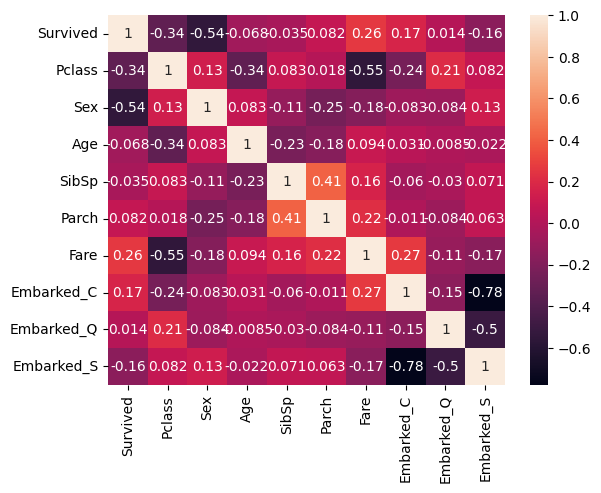

In [546]:
sn.heatmap(dftr.corr(), annot=True)
plt.show()

In [547]:
# dftr.hist(column='Age')
# dftr.hist(column='Pclass')
# dftr.hist(column='Embarked')

In [548]:
dftr.corr() # I can see all correlations now

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.543351,-0.067809,-0.035322,0.081629,0.257307,0.168240,0.013613,-0.155660
Pclass,-0.338481,1.000000,0.131900,-0.335071,0.083081,0.018443,-0.549500,-0.243292,0.206095,0.081720
Sex,-0.543351,0.131900,1.000000,0.082533,-0.114631,-0.245489,-0.182333,-0.082853,-0.083965,0.125722
Age,-0.067809,-0.335071,0.082533,1.000000,-0.232743,-0.176744,0.093856,0.030786,-0.008500,-0.021504
SibSp,-0.035322,0.083081,-0.114631,-0.232743,1.000000,0.414838,0.159651,-0.059528,-0.029797,0.070941
Parch,0.081629,0.018443,-0.245489,-0.176744,0.414838,1.000000,0.216225,-0.011069,-0.084032,0.063036
Fare,0.257307,-0.549500,-0.182333,0.093856,0.159651,0.216225,1.000000,0.269335,-0.108266,-0.166603
Embarked_C,0.168240,-0.243292,-0.082853,0.030786,-0.059528,-0.011069,0.269335,1.000000,-0.150356,-0.778359
Embarked_Q,0.013613,0.206095,-0.083965,-0.008500,-0.029797,-0.084032,-0.108266,-0.150356,1.000000,-0.503651
Embarked_S,-0.155660,0.081720,0.125722,-0.021504,0.070941,0.063036,-0.166603,-0.778359,-0.503651,1.000000


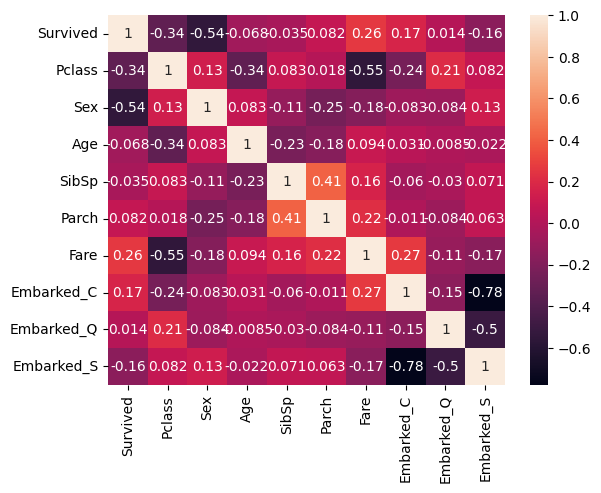

In [549]:
sn.heatmap(dftr.corr(), annot=True)
plt.show()

In [550]:
dftr['Survived'].corr(dftr['Age']) #Checks for correlation between survival and age
# As correlation is -7%, theres a negative but weakly negative correlation between survival and age. So as age goes down, survival does go up but not by much.  


-0.06780914748774236

In [551]:
dftr['Survived'].corr(dftr['Sex'])
# As correlation is -54%, theres a strong negative correlation between survival and gender. So as gender goes down (so becomes 0 meaning female), survival does go up by a lot.
# So males did have a lower chance of surviving.

-0.5433513806577547

In [552]:
children = dftr[dftr['Age'] < 18]
# children.hist()

In [553]:
living_children = dftr[(dftr['Age'] < 18) & (dftr['Survived'] == 1)]
dead_children = dftr[(dftr['Age'] < 18) & (dftr['Survived'] == 0)]

deadchildratio= dead_children.count()/(children.count())
print(deadchildratio) # 46% of kids died

Survived      0.460177
Pclass        0.460177
Sex           0.460177
Age           0.460177
SibSp         0.460177
Parch         0.460177
Fare          0.460177
Embarked_C    0.460177
Embarked_Q    0.460177
Embarked_S    0.460177
dtype: float64


<h1>CLEANING THE TEST DATASET</h1>

In [554]:
dftst=pd.read_csv('datasets/test.csv')

dftst.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [555]:
print(dftst.dtypes)

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [556]:
dftst.drop(['Name','Ticket',"Cabin"],axis=1,inplace=True)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [557]:
nan_rows = dftr[dftr.isna().any(axis=1)]
dftst['Embarked'].fillna("Q", inplace=True)
dftst['Sex'] = dftst['Sex'].replace({'female': 0, 'male': 1})
# dftst['Embarked'] = dftst['Embarked'].replace({'S': 0, 'C': 1, "Q" : 2}).astype(int)

# You need to one hot encode the Embarked column otherwise 0 1 2 would be ordered.
embarked_encoded = pd.get_dummies(dftst["Embarked"], prefix="Embarked")
dftst = pd.concat([dftst, embarked_encoded], axis=1)
dftst = dftst.drop("Embarked", axis=1)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.5,0,0,7.8292,0,1,0
1,893,3,0,47.0,1,0,7.0000,0,0,1
2,894,2,1,62.0,0,0,9.6875,0,1,0
3,895,3,1,27.0,0,0,8.6625,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,1


In [558]:
print(dftst["Age"].median())
print(dftst["Age"].mean())
skewness = dftst["Age"].skew()
print("Skewness:", skewness)
# As skewness is 0.44, it is slightly skewed to the right. So the mean is greater than the median. So I will use the mean of mean and median to fill in the missing values.

27.0
30.272590361445783
Skewness: 0.4573612871503845


In [559]:
dftst['Age'].fillna(28, inplace=True)
dftst['Age'] = dftst['Age'].astype(int)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34,0,0,7.8292,0,1,0
1,893,3,0,47,1,0,7.0000,0,0,1
2,894,2,1,62,0,0,9.6875,0,1,0
3,895,3,1,27,0,0,8.6625,0,0,1
4,896,3,0,22,1,1,12.2875,0,0,1


In [560]:
nan_rowsfare = dftst[dftst['Fare'].isna()]
print(nan_rowsfare)

     PassengerId  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked_C  \
152         1044       3    1   60      0      0   NaN           0   

     Embarked_Q  Embarked_S  
152           0           1  


In [561]:
print(dftst["Fare"].median())
print(dftst["Fare"].mean())
skewness = dftst["Fare"].skew()
print("Skewness:", skewness)
# As skewness is 3.68, it is extremely skewed to the right. I will use the median to fill in the missing values.

14.4542
35.627188489208635
Skewness: 3.6872133081121405


In [562]:
median_faretest = dftst['Fare'].median()
print(median_faretest)
dftst['Fare'].fillna(median_faretest, inplace=True)
dftst.head()

14.4542


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34,0,0,7.8292,0,1,0
1,893,3,0,47,1,0,7.0000,0,0,1
2,894,2,1,62,0,0,9.6875,0,1,0
3,895,3,1,27,0,0,8.6625,0,0,1
4,896,3,0,22,1,1,12.2875,0,0,1


<h1>MODEL BUILDING</h1>

In [563]:
X_train = dftr.drop("Survived", axis=1)
Y_train = dftr["Survived"]
X_test  = dftst.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [564]:
logr = LogisticRegression()
logr.fit(X_train, Y_train)
Y_pred = logr.predict(X_test)

# Used logistic regression and got a 1.2% better result in Kaggle
# After the last update to the code, 17/05/2023, my Kaggle score went a tiny bit down but that's okay. I have better code now.


c:\Users\Aykut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [565]:
submission = pd.DataFrame({"PassengerId": dftst["PassengerId"],"Survived": Y_pred})
# submission.to_csv('submission.csv', index=False)